# Testing algorithmic strategy Vwap_Pivot_SupRes_StochRSI

In [1]:
from datetime import datetime

import psycopg2
import sqlalchemy

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import backtrader as bt
import backtrader.analyzers as btanalyzers

%matplotlib inline
sns.set()

In [2]:
from sqlalchemy import create_engine
# Postgres username, password, and database name
POSTGRES_ADDRESS = 'localhost' ## INSERT YOUR DB ADDRESS IF IT'S NOT ON PANOPLY
POSTGRES_PORT = '5432'
POSTGRES_USERNAME = 'quantam_admin' ## CHANGE THIS TO YOUR PANOPLY/POSTGRES USERNAME
POSTGRES_PASSWORD = 'password' ## CHANGE THIS TO YOUR PANOPLY/POSTGRES PASSWORD
POSTGRES_DBNAME = 'quantam' ## CHANGE THIS TO YOUR DATABASE NAME
# A long string that contains the necessary Postgres login information
postgres_str = ('postgresql://{username}:{password}@{ipaddress}:{port}/{dbname}'
    .format(
        username=POSTGRES_USERNAME,
        password=POSTGRES_PASSWORD,
        ipaddress=POSTGRES_ADDRESS,
        port=POSTGRES_PORT,
        dbname=POSTGRES_DBNAME
    )
)
# Create the connection
cnx = create_engine(postgres_str)

In [3]:
df = pd.read_sql_query('SELECT * FROM stock_data', cnx)

<AxesSubplot:xlabel='timestamp'>

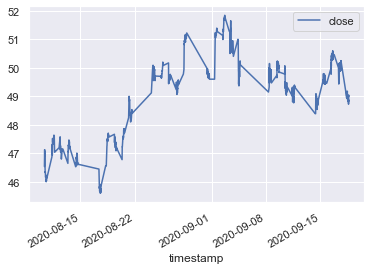

In [4]:
df.plot(x="timestamp", y="close")

In [5]:
class VapSys(bt.Strategy):
    # list of parameters which are configurable for the strategy
    params = dict(pfast=10, pslow=25)  # period for the fast moving average  # period for the slow moving average

    def __init__(self):
        stock = bt.ind.Stochastic()
        rsi = bt.ind.RSI_EMA()
        # sma1 = bt.ind.SmoothedMovingAverage(period=self.p.pfast)  # fast moving average
        # sma2 = bt.ind.SmoothedMovingAverage(period=self.p.pslow)  # slow moving average
        # self.crossover = bt.ind.CrossOver(sma1, sma2)  # crossover signal
        self.sk = stock.lines.percK
        self.sd = stock.lines.percD
        self.c1 = bt.ind.CrossOver(self.sk, self.sd)
        self.c2 = bt.ind.CrossOver(self.sk, 20)
        # self.c3 = bt.ind.CrossOver(20, self.sk)
        self.signal = self.c2


    def next(self):
        if not self.position:  # not in the market
            # if self.crossover > 0:  # if fast crosses slow to the upside
            #     self.buy()  # enter long
            if self.signal > 0:
              self.buy()

        elif self.signal < 0:  # in the market & cross to the downside
            self.close()  # close long position


In [ ]:
cerebro = bt.Cerebro()  # create a "Cerebro" engine instance

# Create a data feed
data = bt.feeds.YahooFinanceData(dataname="AAPL", fromdate=datetime(2016, 1, 1), todate=datetime(2019, 5, 31))

cerebro.adddata(data)  # Add the data feed

cerebro.addstrategy(VapSys)  # Add the trading strategy
cerebro.run()  # run it all
cerebro.plot(
    style='bar',
    numfigs=8,
    iplot=False
)  # and plot it with a single command


In [ ]:
# Analyzer
cerebro.addanalyzer(btanalyzers.SharpeRatio, _name="mysharpe")

the_stats = cerebro.run()
the_stat = the_stats[0]

print("Sharpe Ratio:", the_stat.analyzers.mysharpe.get_analysis())
